In [193]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
class Nodo:
      GuiaT_N :Dict[int, 'Nodo'] = {}     #TAG -> NODO
      GuiaTT_D :Dict[tuple, int] = {}     #TAG-TAG -> DISTANCIA
      GuiaP_N :Dict[tuple, 'Nodo'] = {}   #POSICION -> NODO
      def __init__(self, posicion: tuple):
            self.DISTANCIA_MINIMA = 3
            self.tag = len(Nodo.GuiaT_N)
            Nodo.GuiaT_N[self.tag] = self
            Nodo.GuiaP_N[posicion] = self
            self.vecinos = []
            self.posicion = posicion
      def AgregarVecino(self, vecino: 'Nodo', distancia: int = None):
            #UNE DOS NODOS COMO VECINOS
            vecino = Nodo.GuiaP_N.get(vecino, None)
            if vecino != None:
                  self.vecinos.append(vecino)
                  vecino.vecinos.append(self)
                  dis = self.DISTANCIA_MINIMA + np.random.randint(5)
                  Nodo.GuiaTT_D[(self.tag, vecino.tag)] = distancia if distancia != None else dis
                  Nodo.GuiaTT_D[(vecino.tag, self.tag)] = distancia if distancia != None else dis
      def Reiniciar():
            Nodo.GuiaP_N.clear()
            Nodo.GuiaTT_D.clear()
            Nodo.GuiaP_N.clear()

class Pasajero:
      tag_count = 0
      def __init__(self, tag_inicio = None, tag_final = None) -> None:
            self.tag = Pasajero.tag_count
            Pasajero.tag_count += 1
            lstPT = list(Nodo.GuiaT_N.keys()).copy()
            if tag_inicio == None:
                  k = np.random.randint(len(lstPT))
                  self.Tag_inicio = lstPT[k]
                  lstPT.pop(k)
            else:
                  self.Tag_inicio = tag_inicio
                  
            if tag_final == None:
                  k = np.random.randint(len(lstPT))
                  self.Tag_final = lstPT[k]
            else:
                  self.Tag_final = tag_final
            
      def ReiniciarTags():
            Pasajero.tag_count = 0
            
      def toStr(self):
            return f"{self.tag} : {self.Tag_inicio} -> {self.Tag_final}"
      
class Ruta:
      def __init__(self, distancia = 0, n_tags = [], fijo = False) -> None:
            self.distancia = distancia
            self.n_tags = n_tags
            self.fijo = fijo


class Ciudad:

      def __init__(self, lado: int, n_pasajeros: int) -> None:
            Nodo.Reiniciar()
            Pasajero.ReiniciarTags()
            self.Lado = lado
            #Se define una ciudad cuadriculada
            self.Nodos = np.array([[Nodo((i,j)) for i in range(lado)] for j in range(lado)], dtype=Nodo)
            #Une los distintos nodos como vecinos
            for i in range(lado):
                  for j in range(lado):
                        nposicion = (i,j)
                        nodo_ini = Nodo.GuiaP_N[nposicion]
                        nodo_ini.AgregarVecino((i + 1, j))
                        nodo_ini.AgregarVecino((i, j + 1))
            #DefinirPasajeros
            self.pasajeros = [Pasajero() for i in range(n_pasajeros)]
            self.Mdistancias : Dict[int,Dict[int:Ruta]]= self.GenerarMatrizDistancias()

            
      def MostrarPasajeros(self):
            print(f"Hay {len(self.pasajeros)} pasajeros")
            for p in self.pasajeros:
                  print(p.toStr())
                  
      def GenerarMatrizDistancias(self):
            Distancias = {}        
            NNodos = len(Nodo.GuiaT_N)
            for i in range(self.Lado):
                  for j in range(self.Lado):
                        n_origen :Nodo = Nodo.GuiaP_N[(i,j)]
                        dic_rutas = {n_origen.tag : Ruta(distancia= 0, n_tags= [n_origen.tag], fijo= True)} #El primero nodo se agrega a si mismo como nodo fijo
                        rutas_fijas = [r for r in dic_rutas.values() if r.fijo]
                        
                        while(len(rutas_fijas) != NNodos):
                              #Para todo vecino de cada nodo fijo agregarlo al diccionario de rutas o una version menos pesada
                              #print("Fijos :",[r.n_tags for r in rutas_fijas])
                              for ruta in rutas_fijas:
                                    nodo_final_ruta = Nodo.GuiaT_N[ruta.n_tags[-1]]
                                    for nodo_vecino in nodo_final_ruta.vecinos:
                                          d = Nodo.GuiaTT_D[(nodo_final_ruta.tag, nodo_vecino.tag)] + ruta.distancia
                                          if (nodo_vecino.tag not in dic_rutas.keys() or d < dic_rutas[nodo_vecino.tag].distancia):
                                                nr_n_tags = ruta.n_tags.copy()
                                                nr_n_tags.append(nodo_vecino.tag)
                                                dic_rutas[nodo_vecino.tag] = Ruta(distancia = d,n_tags = nr_n_tags)
                              
                              rnfs = [r for r in dic_rutas.values() if not r.fijo]
                              #print("No fijo :",[r.n_tags for r in rnfs])
                              rnfs.sort(key=lambda r: r.distancia)
                              rnfs[0].fijo = True
                                    
                              rutas_fijas = [r for r in dic_rutas.values() if r.fijo]
                        Distancias[n_origen.tag] = dic_rutas
                              
            return Distancias
      
      def getPasajerosTag(self, lstFaltantes, lstAbordo):
            
            #Cuenta para cada nodo cuantos pasajeros tienen que bajar ahi y cuantos van a subir
            dic_res = {tag : [0,0] for tag in Nodo.GuiaT_N.keys()}
            for pasajero in lstAbordo:
                  dic_res[pasajero.Tag_final][1] += 1

            for pasajero in lstFaltantes:
                  if pasajero not in lstAbordo:
                        dic_res[pasajero.Tag_inicio][0] += 1
            S = []
            #Establece una forma de escribir la cantidad de pasajeros a bajar y subir
            for key in dic_res.keys():
                  P = Nodo.GuiaT_N[key].posicion
                  str1 = f"{dic_res[key][0]}🙍" if dic_res[key][0] != 0 else ""
                  str2 = f"{dic_res[key][1]}⤵" if dic_res[key][1] != 0 else ""
                  str_res = str1 + ("|" if str1 != "" and str2 != "" else "") + str2
                  S.append(str_res)
            return S
      
      
LADO = 10
NPASAJEROS = 20
C = Ciudad(LADO, NPASAJEROS)


In [194]:
from AlgEvo import AE
#Se usara una representacion donde el veiculo tiene capacidad para infinitos pasajeros y donde la cantidad de
#Genes a usar es el doble de la cantidad de pasajeros para representar la ubicacion de recojo y dejar pasajeros
#se realizara un ajuste para que cada pasajero sea recogido antes de ser llevado a su destino
NGENES = NPASAJEROS * 2

def Interpretar(resultados, verboso = False):
      lstAuto = []
      lstLlevados = []
      res = []
      assert len(C.pasajeros) == NPASAJEROS
      for tag in resultados:
            pasajero : Pasajero = C.pasajeros[tag % NPASAJEROS]
            if pasajero in lstAuto:
                  lstAuto.remove(pasajero)
                  lstLlevados.append(pasajero)
                  #Dejar
                  if verboso: print(f"Dejar al pasajero {pasajero.tag} en {pasajero.Tag_final}")
                  res.append(pasajero.Tag_final)
            else:
                  #Recoger
                  lstAuto.append(pasajero)
                  if verboso: print(f"Recoger al pasajero {pasajero.tag} en {pasajero.Tag_inicio}")
                  res.append(pasajero.Tag_inicio)
      assert len(lstLlevados) == NPASAJEROS
      if verboso: print(f"Se han transportado a {len(lstLlevados)} pasajeros")
      return res

def F(X):
      res = []
      for Xi in X:
            distancia = 0
            tags_nodos = Interpretar(Xi)
            for i in range(NGENES - 1): #recorrer todas las ciudades
                  tag = tags_nodos[i]      #Posicion en la que estoy
                  p_tag = tags_nodos[i + 1]     #Posicion a la que ire
                  distancia += C.Mdistancias[tag][p_tag].distancia
            res.append(distancia)
      return res
mAE = AE(NGENES, F, ngeneraciones=400, pop_inicial=50)
res = mAE.Entrenar()




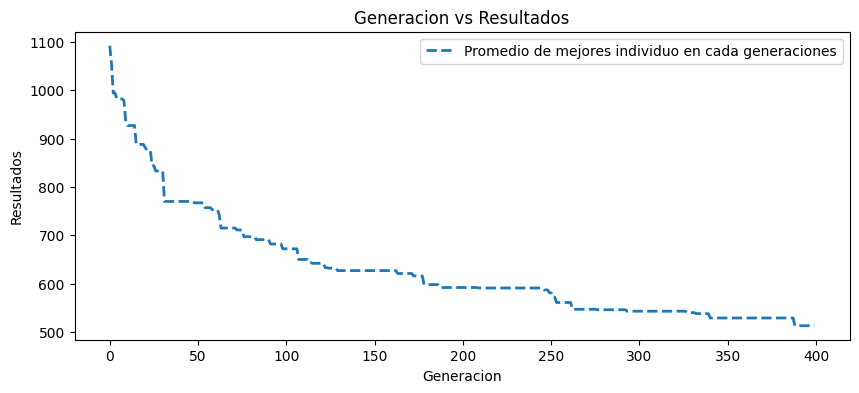

In [195]:
mAE.GraficarResultados()

#### Solucion encontrada

In [196]:
tags_solucion = res[0]

interpretacion = Interpretar(tags_solucion, verboso= True)
recorrido = []
for i in range(len(interpretacion) - 1):
    pi = interpretacion[i]
    pf = interpretacion[i + 1]
    recorrido += C.Mdistancias[pi][pf].n_tags[:-1]
recorrido.append(C.Mdistancias[pi][pf].n_tags[-1])
print("La solucion es:")
print(interpretacion)
print(recorrido)
print(f"El recorrido tine un tamaño de : {len(recorrido)}")

Recoger al pasajero 9 en 7
Recoger al pasajero 7 en 18
Recoger al pasajero 4 en 29
Recoger al pasajero 12 en 38
Recoger al pasajero 6 en 68
Dejar al pasajero 9 en 87
Recoger al pasajero 13 en 95
Recoger al pasajero 17 en 53
Recoger al pasajero 10 en 46
Recoger al pasajero 5 en 4
Recoger al pasajero 14 en 14
Recoger al pasajero 1 en 2
Dejar al pasajero 17 en 13
Recoger al pasajero 16 en 45
Recoger al pasajero 18 en 70
Dejar al pasajero 1 en 84
Dejar al pasajero 16 en 95
Recoger al pasajero 2 en 98
Recoger al pasajero 0 en 89
Dejar al pasajero 5 en 75
Dejar al pasajero 6 en 59
Recoger al pasajero 19 en 29
Dejar al pasajero 12 en 26
Dejar al pasajero 7 en 16
Dejar al pasajero 2 en 3
Recoger al pasajero 3 en 21
Dejar al pasajero 14 en 11
Recoger al pasajero 11 en 23
Recoger al pasajero 8 en 32
Dejar al pasajero 11 en 32
Recoger al pasajero 15 en 33
Dejar al pasajero 13 en 33
Dejar al pasajero 10 en 34
Dejar al pasajero 8 en 43
Dejar al pasajero 4 en 45
Dejar al pasajero 0 en 36
Dejar al pa

# Graficando una solucion

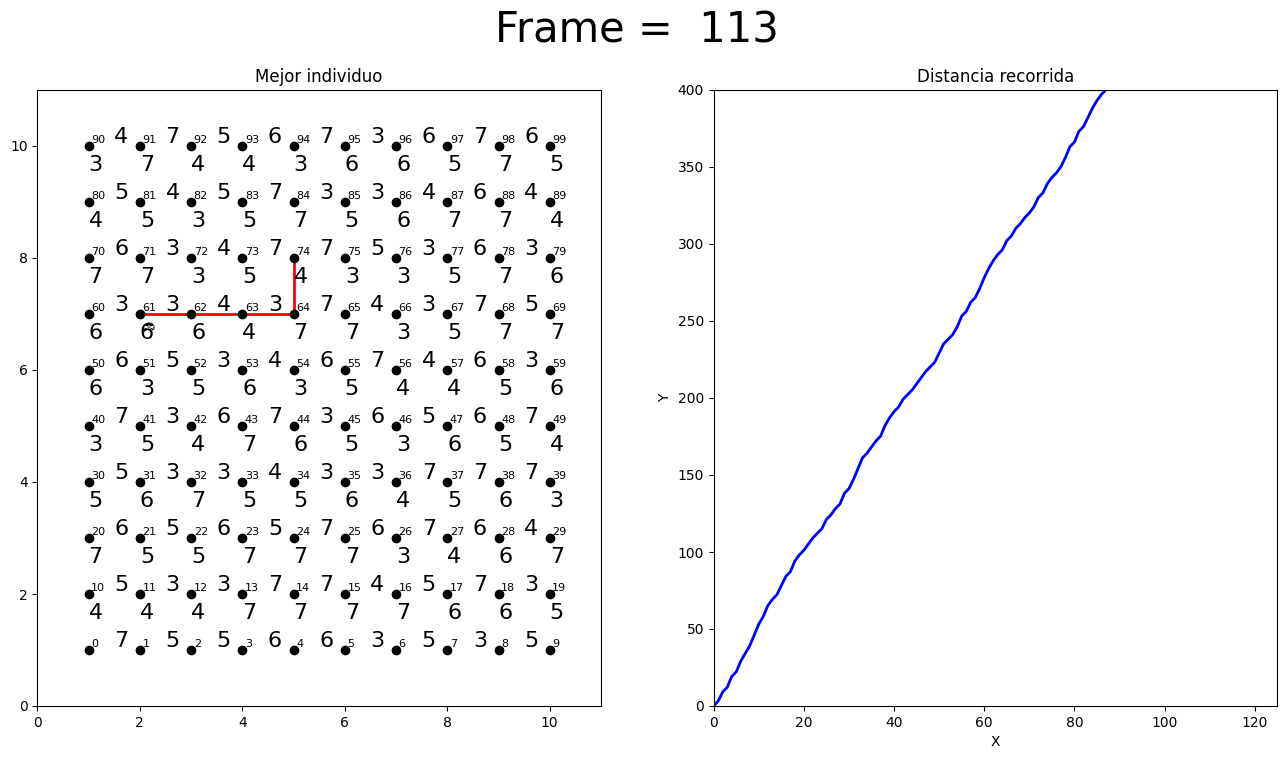

In [197]:
from matplotlib import animation
from IPython.display import HTML

class Graficador_CityCar:
      def __init__(self, c : Ciudad, solucion: list) -> None:
            self.ciudad = c
            self.solucion = solucion
            #Constantes
            self.Pading = 1
            self.GDis = 1
            self.FS = 8
            self.Elevacion = 0.05

            self.Abordo:list[Pasajero] = []
            self.LLevados:list[Pasajero] = []
            self.Pendientes:list[Pasajero] = self.ciudad.pasajeros

      def Reiniciar(self):
            self.LINEAS = [self.ax1.plot([], [], 'r', lw=2) for i in range(len(self.solucion))]
            self.PASAJEROSPN = [self.ax1.text(Nodo.GuiaT_N[i].posicion[0] + self.Pading,
                                              Nodo.GuiaT_N[i].posicion[1] + self.Pading + self.Elevacion* 5,
                                              "", fontsize=self.FS, fontname='Segoe UI Emoji') 
                                for i in range(LADO * LADO)]
            self.TAXI_PPOS = [self.ax1.text(Nodo.GuiaT_N[i].posicion[0] + self.Pading,
                                              Nodo.GuiaT_N[i].posicion[1] + self.Pading - self.Elevacion* 5,
                                              "", fontsize=self.FS, fontname='Segoe UI Emoji') 
                                for i in range(LADO * LADO)]
            self.recorrido = [0]
            
      def Graficar(self):
            # create a figure and axes
            fig = plt.figure(figsize=(16,8))
            self.ax1 = plt.subplot(1,2,1)   
            self.ax2 = plt.subplot(1,2,2)
            
            self.Reiniciar()
            
            self.ax1.set_title('Mejor individuo')
            self.ax1.set_xlim((0, LADO + self.Pading))            
            self.ax1.set_ylim((0, LADO + self.Pading))
            self.ax1.set_xlabel('')
            self.ax1.set_ylabel('')
            self.GraficarFondo(self.ax1)
            
            self.ax2.set_xlim((0,len(self.solucion) + 10))
            self.ax2.set_ylim((0,400))
            self.ax2.set_xlabel('X')
            self.ax2.set_ylabel('Y')
            self.ax2.set_title('Distancia recorrida')
            
            
            self.txt_title = fig.suptitle('', fontsize=30)
            
            self.line1, = self.ax2.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
            self.line2, = self.ax2.plot([], [], 'r', lw=2)
            
            anim = animation.FuncAnimation(fig, self.drawframe, frames= len(self.solucion), interval=120, blit=True)
            return HTML(anim.to_html5_video())
      def GraficarFondo(self, ax1):
            for nodo in Nodo.GuiaT_N.values():
                  X = nodo.posicion[0] + self.Pading
                  Y = nodo.posicion[1] + self.Pading
                  ax1.plot(X, Y, 'o', c = "black")
                  ax1.text(X + self.Elevacion, Y + self.Elevacion, nodo.tag, fontsize = self.FS)
                  for nodo_vecino in nodo.vecinos:
                        if nodo_vecino.tag > nodo.tag: continue
                        Xv = nodo_vecino.posicion[0] + self.Pading
                        Yv = nodo_vecino.posicion[1] + self.Pading
                        d = Nodo.GuiaTT_D[(nodo.tag, nodo_vecino.tag)]
                        ax1.text(X/2 + Xv/2, Y/2 + Yv/2 + self.Elevacion, d, fontsize= 3*2 * self.FS/ 3)
                       
                        
      def drawframe(self,n):
            N = n - 1
            nodo_actual = Nodo.GuiaT_N[self.solucion[N + 1]]
            for i in range(len(self.TAXI_PPOS)):
                  self.TAXI_PPOS[i].set_text("🚕" if nodo_actual.tag == i else "") 
                  
            
            for p in self.Pendientes.copy():
                  if p not in self.Abordo and p.Tag_inicio == nodo_actual.tag:
                        self.Abordo.append(p)

            for p in self.Abordo.copy():
                  if p.Tag_final == nodo_actual.tag:
                        self.LLevados.append(p)
                        self.Abordo.remove(p)
                        self.Pendientes.remove(p)
            if N != -1: 
                  linea = self.LINEAS[N][0]
                  nodo_anterior = Nodo.GuiaT_N[self.solucion[N]]
                  Xl = [nodo_anterior.posicion[0] + self.Pading, nodo_actual.posicion[0] + self.Pading]
                  Yl = [nodo_anterior.posicion[1] + self.Pading, nodo_actual.posicion[1] + self.Pading]
                  linea.set_data(Xl, Yl)
                  self.txt_title.set_text('Frame = {0:4d}'.format(N))
                  self.recorrido.append(self.recorrido[-1] + Nodo.GuiaTT_D[(nodo_actual.tag,nodo_anterior.tag)])
                  
            if(N - 4 >= 0):
                  linea = self.LINEAS[N - 4][0]
                  linea.set_data([], [])
                  
            S = self.ciudad.getPasajerosTag(self.Pendientes, self.Abordo)
            for i in range(len(self.PASAJEROSPN)):
                        self.PASAJEROSPN[i].set_text(S[i])      
            
            self.line1.set_data(range(len(self.recorrido)), self.recorrido)
            
            return (self.line1,self.line2)
      
Gcity = Graficador_CityCar(C, recorrido)      
Gcity.Graficar()